In [68]:
import nltk
from os import getcwd
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 
import os
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [5]:
print(len(all_positive_tweets))
print(len(all_negative_tweets))

5000
5000


In [6]:
test_pos = all_positive_tweets

In [7]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [8]:
print(len(test_x))
print(len(train_x))

2000
8000


In [9]:
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [10]:
print(train_y.shape)
print(test_y.shape)

(8000, 1)
(2000, 1)


In [11]:
test_y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [17]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [18]:
def process_tweet(tweet):
 
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [36]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [61]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))
freqs

type(freqs) = <class 'dict'>
len(freqs) = 11338


{('followfriday', 1.0): 23,
 ('top', 1.0): 30,
 ('engag', 1.0): 7,
 ('member', 1.0): 14,
 ('commun', 1.0): 27,
 ('week', 1.0): 72,
 (':)', 1.0): 2847,
 ('hey', 1.0): 60,
 ('jame', 1.0): 7,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 80,
 ('call', 1.0): 27,
 ('contact', 1.0): 4,
 ('centr', 1.0): 1,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 6,
 ('assist', 1.0): 1,
 ('mani', 1.0): 28,
 ('thank', 1.0): 504,
 ('listen', 1.0): 14,
 ('last', 1.0): 39,
 ('night', 1.0): 55,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 41,
 ('track', 1.0): 5,
 ('scotland', 1.0): 2,
 ('congrat', 1.0): 15,
 ('yeaaah', 1.0): 1,
 ('yipppi', 1.0): 1,
 ('accnt', 1.0): 2,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 57,
 ('blue', 1.0): 8,
 ('tick', 1.0): 1,
 ('mark', 1.0): 1,
 ('fb', 1.0): 4,
 ('profil', 1.0): 2,
 ('15', 1.0): 4,
 ('day', 1.0): 187,
 ('one', 1.0): 90,
 ('irresist', 1.0): 2,
 ('flipkartfashionfriday', 1.0): 16,
 ('like', 1.0): 187,
 ('keep', 1.0): 55,
 ('love', 1.0): 336,
 

In [38]:
def sigmoid(z): 

    h = 1/(1+np.exp(-z))
    
    return h

In [39]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = x@theta
        
        # get the sigmoid of z
        h = [[sigmoid(i[0])] for i in z]
        
        # calculate the cost function
        J = -1.0/m*(np.dot(y.T,np.log(h))+np.dot((np.ones((m,1))-y).T,np.log(np.ones((m,1))-h)))

        # update the weights theta
        theta = theta-1.0*alpha/m*(x.T@(h-y))
        

    print(J)
    J = float(J)
    return J, theta

In [51]:

def extract_features(tweet, freqs):
  
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    

    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)

    assert(x.shape == (1, 3))
    return x

In [52]:
train_x[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

In [53]:
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.00e+00 3.02e+03 6.10e+01]]


In [62]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

X

array([[1.000e+00, 3.020e+03, 6.100e+01],
       [1.000e+00, 3.573e+03, 4.440e+02],
       [1.000e+00, 3.005e+03, 1.150e+02],
       ...,
       [1.000e+00, 1.440e+02, 7.830e+02],
       [1.000e+00, 2.050e+02, 3.890e+03],
       [1.000e+00, 1.890e+02, 3.974e+03]])

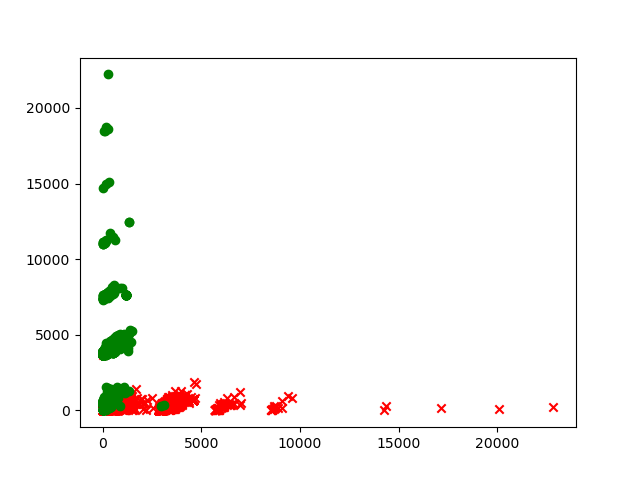

In [69]:
condition = np.arange(len(X)) < 4000

# Split the data points based on the condition
X_red = X[condition]
X_green = X[~condition]

# Create the scatter plot
plt.scatter(X_red[:, 1], X_red[:, 2], marker='x', c='r', label='x < 4000')
plt.scatter(X_green[:, 1], X_green[:, 2], marker='o', c='g', label='x >= 4000')

plt.show()

In [71]:
def compute_cost(X, y, w, b):
  
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i],w) + b           #(n,)(n,)=scalar
        cost = cost + (f_wb_i - y[i])**2
    cost = cost/(2*m)
    return cost 


In [76]:
# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

[[0.24215474]]
The cost after training is 0.24215474.
The resulting vector of weights is [7e-08, 0.00052391, -0.00055517]


In [80]:
y_pred_u = sigmoid(np.squeeze(X@theta))
y_pred_u

array([0.82467415, 0.83554296, 0.81913589, ..., 0.41113904, 0.11382748,
       0.10839464])

In [56]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.squeeze(x@theta))

    ### END CODE HERE ###
    
    return y_pred

In [57]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))

I am happy -> 0.518581
I am bad -> 0.494339
this movie should have been great. -> 0.515331
great -> 0.515464
great great -> 0.530899
great great great -> 0.546274
great great great great -> 0.561562


In [58]:
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

0.8163691176336204

In [59]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = sum(y_hat == test_y.squeeze())/len(y_hat)

    ### END CODE HERE ###
    
    return accuracy

In [60]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950
